In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [2, 2] # inches
mpl.rcParams['font.size'] = 8

# Define a function to do the most common plotting task
def xyplot(x1=None, y1=None, x2=None, y2=None, x3=None, y3=None, title=None, fname=None):
    plt.figure()
    if x1 is not None and y1 is not None:
        plt.plot(x1,y1,'b.')
    if x2 is not None and y2 is not None:
        plt.plot(x2,y2,'k-')
    if x3 is not None and y3 is not None:
        plt.plot(x3,y3,'r-')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.tight_layout()
    if fname:
        plt.savefig(fname)

First, we create a simple linear model with some noise added. We plot the underlying trend (black line) and also the data points (blue). The random seed is set explicitly so that the graph can be reproduced.

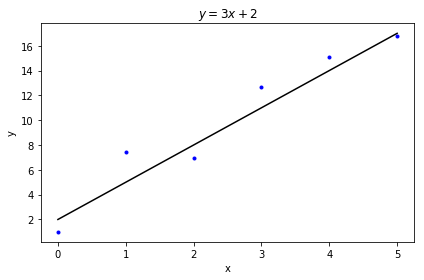

In [2]:
# model is y = 3x+2
np.random.seed(123123)
x = np.array([0, 1, 2, 3, 4, 5])
y = 3*x+2
# Add the noise
t = y + 5*(np.random.rand(6)-0.5)
xyplot(x,t,x2=x,y2=y,title=r'$y=3x+2$',fname='simple-linear.pdf')

Plot the data (blue points), the trend (black line), and the residuals (red lines)

In [ ]:
plt.plot(x,y,'k-')
plt.plot(x,t,'b.')
for i,j in enumerate(x):
    plt.plot([j,j],[y[i],t[i]],'r-')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.title(r'$y=3x+2+\epsilon$')
plt.savefig('simple-linear-residuals.pdf',)

We now introduce a working example that we will refer to frequently. We generate data from an underlying function $y=\sin(2\pi x)$ and investigate how different methods are able to learn the trend.

In [ ]:
# First, define the function using a lambda expression because it is very simple
f = lambda x: np.sin(2*np.pi*x)
# Now we generate two datasets. One is defined on a high-resolution x-grid so we can plot the trend. The other is a lower-resolution sampling
# The trend line
x0 = np.linspace(-1,1,1000)
y0 = f(x0) # underlying function
# Low-res subsampling
x = np.linspace(-1,1,10)
y = f(x)
# Plot both
xyplot(x,y,x2=x0,y2=y0,title=r'$y=sin(2\pi x)$',fname='sin.pdf')

Now we do a naive fit of different degree of polynomial to the data, using the normal equations
$$\mathbf{\Phi}^\mathrm{T}\mathbf{\Phi}\mathbf{w} = \mathbf{\Phi}^\mathrm{T}\mathbf{y}$$
where $\mathbf{\Phi}_{ij} = \phi_j(x_i)$, basis function $\phi_j$ evaluated at data point $x_i$.

In [ ]:
# Maximum degree of fit
M = 10
# Empty list to record the RMS errors
rsq = []
# Empty list to record the weights for each regression run
weights = []
# For each degree of polynomaial fit
for i in range(0,M):
    # Create the Matrix of basis functions for the sampled data
    Phi = np.array([pow(x,j) for j in range(0,i+1)]).transpose()
    # Create a high-resolution basis matrix so that we can plot the fitted polynomial
    hiPhi = np.array([pow(x0,j) for j in range(0,i+1)]).transpose()
    # Solve the normal equations using a standard solver
    w = np.linalg.solve(np.matmul(Phi.transpose(),Phi), np.matmul(Phi.transpose(),y))
    # record the weights
    weights.append(w)
    # Compute the estimated values of the data points so we can compute the error
    yp = np.matmul(Phi,w)
    # compute the RMS error
    rsq.append(np.sqrt(np.sum(pow(y-yp,2)/x.size)))
    # plot the data and the estimates of the model for the low-res and high-res samplings
    xyplot(x, y, x2=x0, y2=y0, x3=x0, y3=np.matmul(hiPhi,w), title='M='+str(i), fname='sin-M'+str(i)+'.pdf')
# Plot the error curve
plt.figure()
plt.plot(rsq,'k.-')
plt.xlabel('Degree of fit')
plt.ylabel('RMS Error')
plt.tight_layout()
plt.savefig('sin-rms.pdf')
# Print out the weights
for i,w in enumerate(weights):
    print(str(i) + ' & ' + ' & '.join(['{:5.2f}'.format(i) for i in w]))
    

We now add some random noise to the data and repeat

In [ ]:
# Add the random noise
np.random.seed(123123)
y = f(x) + 0.5*np.random.randn(x.size)
# Maximum degree of fit
M = 10
# Empty list to record the RMS errors
rsq = []
# Empty list to record the weights for each regression run
weights = []
# For each degree of polynomaial fit
for i in range(0,M):
    # Create the Matrix of basis functions for the sampled data
    Phi = np.array([pow(x,j) for j in range(0,i+1)]).transpose()
    # Create a high-resolution basis matrix so that we can plot the fitted polynomial
    hiPhi = np.array([pow(x0,j) for j in range(0,i+1)]).transpose()
    # Solve the normal equations using a standard solver
    w = np.linalg.solve(np.matmul(Phi.transpose(),Phi), np.matmul(Phi.transpose(),y))
    # record the weights
    weights.append(w)
    # Compute the estimated values of the data points so we can compute the error    
    yp = np.matmul(Phi,w)
    # compute the RMS error
    rsq.append(np.sqrt(np.sum(pow(y-yp,2)/x.size)))
    # plot the data and the estimates of the model for the low-res and high-res samplings
    xyplot(x, y, x2=x0, y2=y0, x3=x0, y3=np.matmul(hiPhi,w), title='M='+str(i), fname='sin-noisy-M'+str(i)+'.pdf')
# Plot the error curve
plt.figure()
plt.plot(rsq,'k.-')
plt.xlabel('Degree of fit')
plt.ylabel('RMS Error')
plt.tight_layout()
plt.savefig('sin-noisy-rms.pdf')
# Print out the weights
for w in weights:
    print(' & '.join(['{:5.2f}'.format(i) for i in w]))

Demonstrate that add additional data points changes the outcome and the model no longer overfits.

In [ ]:
np.random.seed(12345)
x1 = np.linspace(-1,1,50)
y1 = f(x1) + 0.5*np.random.randn(x1.size)
# Maximum degree of fit
M = 10
# Empty list to record the RMS errors
rsq = []
# Empty list to record the weights for each regression run
weights = []
# For each degree of polynomaial fit
for i in range(0,M):
    # Create the Matrix of basis functions for the sampled data
    Phi = np.array([pow(x1,j) for j in range(0,i+1)]).transpose()
    # Create a high-resolution basis matrix so that we can plot the fitted polynomial
    hiPhi = np.array([pow(x0,j) for j in range(0,i+1)]).transpose()
    # Solve the normal equations using a standard solver
    w = np.linalg.solve(np.matmul(Phi.transpose(),Phi), np.matmul(Phi.transpose(),y1))
    # record the weights
    weights.append(w)
    # Compute the estimated values of the data points so we can compute the error    
    yp = np.matmul(Phi,w)
    # compute the RMS error
    rsq.append(np.sqrt(np.sum(pow(y1-yp,2)/x.size)))
    # plot the data and the estimates of the model for the low-res and high-res samplings
    xyplot(x1, y1, x2=x0, y2=y0, x3=x0, y3=np.matmul(hiPhi,w), title='M='+str(i), fname='sin-noisy-highres-M'+str(i)+'.pdf')
# Plot the error curve
plt.figure()
plt.plot(rsq,'k.-')
plt.xlabel('Degree of fit')
plt.ylabel('RMS Error')
plt.tight_layout()
plt.savefig('sin-noisy-highres-rms.pdf')
# Print out the weights
for w in weights:
    print(' & '.join(['{:5.2f}'.format(i) for i in w]))

An alternative way to prevent overfitting is to employ a regularisation method. Here, we use $L_2$ regularisation, which employs the loss function

$$\mathcal{L}(\mathbf{w}) = \left(\mathbf{y}-\mathbf{\Phi}\mathbf{w}\right)^\mathrm{T}\left(\mathbf{y}-\mathbf{\Phi}\mathbf{w}\right) + \lambda\mathbf{w}^\mathrm{T}\mathbf{w}$$

which is minimised by solving
$$\left(\mathbf{\Phi}^\mathrm{T}\mathbf{\Phi}-\lambda\mathbf{I}\right)\mathbf{w} = \mathbf{\Phi}^\mathrm{T}\mathbf{y}$$

We will see here that whilst too little regularisation leads to overfitting, too much leads to a loss of expressive power in the model


In [ ]:
# Generate data with random noise
np.random.seed(12345)
y = f(x) + 0.5*np.random.randn(x.size)
# Empty lists to store results
rsq = []
weights = []
# Create a basis matrix for a high-order fit so we can assess overfitting.
Phi = np.array([pow(x,i) for i in range(0,10)]).transpose()
# Basis for high-order, high res fit so we can plot the fit.
hiPhi = np.array([pow(x0,i) for i in range(0,10)]).transpose()
# Define the values of the regularisation parameter 
loglambda = [-6, -5, -4, -3, -2, -1]
for l in loglambda:
    # Solve the normal equations using a standard solver
    w = np.linalg.solve(np.matmul(Phi.transpose(),Phi)-pow(10,l)*np.eye(y.size), np.matmul(Phi.transpose(),y))
    # record the weights
    weights.append(w)
    # Compute the estimated values of the data points so we can compute the error
    yp = np.matmul(Phi,w)
    # compute the RMS error
    rsq.append(np.sqrt(np.sum(pow(y-yp,2)/x.size)))
    # plot the data and the estimates of the model for the low-res and high-res samplings
    xyplot(x, y, x2=x0, y2=y0, x3=x0, y3=np.matmul(hiPhi,w), title=r'$\log(\lambda)$='+str(l), fname='sin-noisy-L2-L'+str(l)+'.pdf')
# Plot the error curve
plt.figure()
plt.plot(loglambda,rsq,'k.-')
plt.xlabel(r'$\log(\lambda)$')
plt.ylabel('RMS Error')
plt.tight_layout()
plt.savefig('sin-noisy-L2-rms.pdf')
for w in weights:
    print(' & '.join(['{:5.2f}'.format(i) for i in w]))

Let us now try some validation. Let's generate a new 20-point dataset.

In [ ]:
np.random.seed(123123)
x = np.atleast_2d(np.random.permutation(np.linspace(-1,1,20)))
y = f(x) + 0.25*np.random.randn(x.size)
# High-resolution dataset
xt = np.linspace(-1,1,1000)
yt = f(xt)
# Combine the x and y coordinates into a single nump array so that we can split them up into the different sets more easily.
D = np.concatenate([x.T,y.T],axis=1)
xyplot(D[:,0],D[:,1],x2=xt,y2=yt,title='Full Dataset')

Split the dataset into Training, Validation and Testing sets

In [ ]:
# Split the dataset
TrainSet = D[0:10]
ValidationSet = D[10:15]
TestSet = D[15:20]

In [ ]:
# Define the models. We will look a polynomials of order 1 to 10
# Create empty lists for the results.
weights = []
train_error = []
validation_error = []
max_order=10
for i in range(max_order):
    PhiTrain = np.array([pow(TrainSet[:,0],j) for j in range(0,i+1)]).transpose()
    PhiValid = np.array([pow(ValidationSet[:,0],j) for j in range(0,i+1)]).transpose()
    # Train the model
    w = np.linalg.solve(np.matmul(PhiTrain.transpose(),PhiTrain), np.matmul(PhiTrain.transpose(),TrainSet[:,1]))
    print(w)
    weights.append(w)
    # Compute the error on the training set
    train_error.append(np.sqrt(np.average(pow(TrainSet[:,1]-np.matmul(PhiTrain,w),2))))
    # Compute the error on the validation set
    validation_error.append(np.sqrt(np.average(pow(ValidationSet[:,1]-np.matmul(PhiValid,w),2))))
    plt.figure()
    # Plot the training data
    plt.plot(TrainSet[:,0],TrainSet[:,1],'r.')
    # Plot the validation data
    plt.plot(ValidationSet[:,0],ValidationSet[:,1],'b.')
    # Plot the real trend line
    plt.plot(xt,yt,'k-')
    # Plot the high-res fitted curve
    plt.plot(xt,np.matmul(np.array([pow(xt,j) for j in range(0,i+1)]).transpose(),w),'r-')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('M='+str(i))
    plt.tight_layout()
    plt.savefig('Validation-M='+str(i)+'.pdf')
# plot the training and validation errors
plt.figure()
plt.plot(np.linspace(0,max_order-1,max_order),train_error, 'k.-')
plt.plot(np.linspace(0,max_order-1,max_order),validation_error, 'b.-')
plt.xlabel('Degree of fit')
plt.ylabel('RMS Error')
plt.tight_layout()
plt.savefig('Validation-Errors.pdf')


The plot of the training error and the validation error suggests that $M=5$ is the best choice for the polynomila order: adding higher order terms does not change the error very much, and so we apply Ockham's razor and select the simplest model. There is one final task: to compute the error on the unseen test set to see if we have really learned the model.

In [ ]:
# Optimal fit is M=5, compute test error for this
Phi = np.array([pow(TestSet[:,0],j) for j in range(0,6)]).transpose()
test_error = np.sqrt(np.average(pow(TestSet[:,1]-np.matmul(Phi,weights[5]),2)))
print(test_error)

This is comparable to the validation error - we would not expect it to be quite as low because the test data is unseen. Note that other order fits may fit the test data even more accurately - but this is a consequence of the relatively small sampling.